<h1>Replicating Multiclass Model Architecture from 'Explanations of Augmentation Methods for Deep Learning ECG Classifications'</h1>

<a href='https://link.springer.com/chapter/10.1007/978-3-031-66535-6_30#Tab1'>Link To Article</a>

In [3]:
import os
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

import keras
from keras.utils import to_categorical, plot_model # type: ignore
from keras.models import Sequential # type: ignore
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, GlobalAveragePooling1D, BatchNormalization, Activation # type: ignore
import tensorflow as tf

In [4]:
# Importing user-defined module
from Scripts.ptbxl_mc import *

<h3>Checking For Available GPUs:</h3>

In [5]:
gpus = tf.config.list_physical_devices('GPU')

In [6]:
if gpus:
    for gpu in gpus:
        print(f'GPU Name: {gpu.name}')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs, ', len(logical_gpus), 'Logical GPUs')

else:
    print('No GPUs found')

No GPUs found


<h3>Loading PTB-XL Database from ".npz" File:</h3>

In [7]:
npz_file = r'C:\Users\loera\OneDrive\Python Projects\College\ECG\Processed Datasets\MC_dataset.npz'

In [8]:
ptbxl_df, signals_df = load_database(npz_file)

<h3>Splitting Data into Training and Testing Sets:</h3>

In [9]:
# Formatting the signals and superclassses to numpy arrays
signals = signals_df.to_numpy(dtype=float)
superclasses = ptbxl_df.loc[:,'superclasses'].to_numpy(dtype=str)

In [10]:
# Assigns data (signals) to X
X = signals

# Assigns labels (superclasses) to Y
Y = superclasses

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(17110, 5000) (17110,)
(4278, 5000) (4278,)


<h3>Counting Instances of each Superclass:</h3>

In [13]:
from collections import Counter

# Counting instances in training dataset
print('Training Set Intances:\n')
train_counter = Counter(y_train)

for label, num in train_counter.items():
    print(f'{label}: {num}')
    
# Counting instances in testing dataset
print('\nTesting Set Intances:\n')
test_counter = Counter(y_test)

for label, num in test_counter.items():
    print(f'{label}: {num}')

Training Set Intances:

CD: 2996
STTC: 3044
NORM: 7366
MI: 2725
HYP: 979

Testing Set Intances:

NORM: 1808
CD: 770
STTC: 791
MI: 659
HYP: 250


<h3>Encoding Both Training and Testing Labels:</h3>

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [15]:
# Showing original versus encoded labels
print('Encoded Training Labels:', y_train_encoded)
print('Original Training Labels:', label_encoder.inverse_transform(y_train_encoded))

print('\nEncoded Testing Labels:', y_test_encoded)
print('Original Testing Labels:', label_encoder.inverse_transform(y_test_encoded))

Encoded Training Labels: [0 0 4 ... 0 4 0]
Original Training Labels: ['CD' 'CD' 'STTC' ... 'CD' 'STTC' 'CD']

Encoded Testing Labels: [3 3 0 ... 3 3 3]
Original Testing Labels: ['NORM' 'NORM' 'CD' ... 'NORM' 'NORM' 'NORM']


In [16]:
# Converting training and testing labels into one-hot encoding
y_train = to_categorical(y_train_encoded, 5)
y_test = to_categorical(y_test_encoded, 5)

In [17]:
y_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [18]:
y_test

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [19]:
print(y_train.shape, y_test.shape)

(17110, 5) (4278, 5)


<h3>Defining How to Plot Graphs:</h3>

In [20]:
def plot_graphs(history) -> None:
    '''
    Plots 3 graphs using a sequential model's history: Training vs. Validation Loss, Training vs. Validation Accuracy,
    and Training vs. Validation AUC.
    
    Args:
        history: A history object (i.e., a record of training and validation metrics)
    
    Returns:
        None:
    '''
    # Plots training loss versus validation loss
    plt.plot(history.epoch, history.history['loss'], 'b', label='Training Loss')
    plt.plot(history.epoch, history.history['val_loss'], 'g', label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()
    
    # Plots training accuracy versus validation accuracy
    plt.plot(history.epoch, history.history['Accuracy'], 'b', label='Training Accuracy')
    plt.plot(history.epoch, history.history['val_Accuracy'], 'g', label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()
    
    # Plots training area under curve versus validation area under curve
    plt.plot(history.epoch, history.history['AUC'], 'b', label='Training AUC')
    plt.plot(history.epoch, history.history['val_AUC'], 'g', label='Validation AUC')
    plt.legend()    
    plt.title('AUC')
    plt.show()

<h3>Defining Functions for Evaluating the Model:</h3>

In [21]:
def evaluate_model(model: keras.Sequential, test_data: np.ndarray, test_labels: np.ndarray) -> list[float]:
    '''
    Evaluates a pre-trained model on the test data provided.
    
    Args:
        model: The pre-trained model to be evaluated
        test_data: A matrix of shape (n_samples, n_time_points)
        test_labels: The labels corresponding the the test/validation dataset
        
    Returns:
        tuple: A two-element tuple, containing the model's loss and accuracy scores
    '''
    score = model.evaluate(test_data, test_labels, verbose=1)
    
    print(f'\nLoss on test data: {score[0]:.2f}')
    print(f'\nAccuracy on test data: {score[1]:.2f}')
    
    return score

In [22]:
def model_predict(model: keras.Sequential, test_data: np.ndarray, test_labels: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    '''
    Generates predictions using the inputted model and test data. Returns the true class labels along with the predicted 
    labels for the test data.
    
    Args:
        model: The pre-trained model that will be generating predictions
        test_data: A matrix of shape: (n_samples, n_time_points)
        test_labels: The labels corresponding to the test/validation dataset
        
    Returns:
        tuple: A two-element tuple containing the ground truth labels and the model's predicted labels
    '''
    y_test_pred = model.predict(test_data)
    
    # Taking the class with the highest probability based off the model's predictions
    y_hat = np.argmax(y_test_pred, axis=1)
    
    y_test = np.argmax(test_labels, axis=1)
    
    return (y_test, y_hat)

In [23]:
def show_confusion_matrix(test_labels: np.ndarray, prediction_labels: np.ndarray, classes: np.ndarray):
    '''
    Visualizes the performance of a model via a confusion matrix.
    
    Args:
        test_labels: The ground truth labels
        prediction_labels: The generated labels predicted by a pre-trained model
        classes: The labels of the unique classes within the dataset (i.e., [CD, HYP, MI, NORM, STTC])
        
    Returns:
        Figure: The confusion matrix figure  
    '''
    matrix = confusion_matrix(test_labels, prediction_labels)
    
    plt.figure(figsize=(6, 4))
    sns_hm=sns.heatmap(matrix,
                         cmap="YlGnBu",
                         linecolor='white',
                         linewidths=1,
                         xticklabels=classes,
                         yticklabels=classes,
                         annot=True,
                         fmt="d")
    
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    figure=sns_hm.get_figure()  
    plt.show()
    
    return figure

<h3>Generating the CNN Model:</h3>

In [24]:
def generate_1D_model() -> keras.Sequential:
    '''
    Generates and returns a Keras sequential CNN model with 7 convolutional blocks. The initial 6 blocks consist of 1D 
    convolutional layers with ReLU activation, batch normalization, max pooling, and dropout layers. The final block
    implements a 1D convolutional layer, however, it performs global average pooling and has a larger droput value.
    
    Args:
        None:
        
    Returns:
        keras.Sequential: The model generated
    '''
    model = Sequential([Input(shape=(5000,1))])
    
    # Convolutional Block 1
    model.add(Conv1D(32, 3, name='conv1'))
    model.add(BatchNormalization(name='bn1'))
    model.add(Activation('relu', name='relu1'))
    model.add(MaxPooling1D(2, name='max1'))
    model.add(Dropout(0.2, name='drop1'))
    
    # Convolutional Block 2
    model.add(Conv1D(64, 3, name='conv2'))
    model.add(BatchNormalization(name='bn2'))
    model.add(Activation('relu', name='relu2'))
    model.add(MaxPooling1D(2, name='max2'))
    model.add(Dropout(0.2, name='drop2'))
    
    # Convolutional Block 3
    model.add(Conv1D(128, 3, name='conv3'))
    model.add(BatchNormalization(name='bn3'))
    model.add(Activation('relu', name='relu3'))
    model.add(MaxPooling1D(2, name='max3'))
    model.add(Dropout(0.2, name='drop3'))
    
    # Convolutional Block 4
    model.add(Conv1D(256, 3, name='conv4'))
    model.add(BatchNormalization(name='bn4'))
    model.add(Activation('relu', name='relu4'))
    model.add(MaxPooling1D(2, name='max4'))
    model.add(Dropout(0.2, name='drop4'))
    
    # Convolutional Block 5
    model.add(Conv1D(512, 3, name='conv5'))
    model.add(BatchNormalization(name='bn5'))
    model.add(Activation('relu', name='relu5'))
    model.add(MaxPooling1D(2, name='max5'))
    model.add(Dropout(0.2, name='drop5'))
    
    # Convolutional Block 6
    model.add(Conv1D(1024, 3, name='conv6'))
    model.add(BatchNormalization(name='bn6'))
    model.add(Activation('relu', name='relu6'))
    model.add(MaxPooling1D(2, name='max6'))
    model.add(Dropout(0.2, name='drop6'))
    
    # Convolutional Block 7
    model.add(Conv1D(2048, 3, name='conv7'))
    model.add(BatchNormalization(name='bn7'))
    model.add(Activation('relu', name='relu7'))
    model.add(GlobalAveragePooling1D(name='gap1'))
    model.add(Dropout(0.5, name='drop7'))
    
    # Dense Layer
    model.add(Dense(5, name='dense1', activation='softmax'))
    
    return model

<h3>Defining Callback for Model Traning:</h3>

In [25]:
# Checkpoint Folder
chkpt_folder = os.path.join(os.getcwd(), 'Training Sessions', 'Article Multiclass', 'MC_CNN_Weights')

# Checkpoint Path
chkpt_path = os.path.join(chkpt_folder, 'CustomCNN_Lead2_{epoch}.weights.h5')

In [26]:
print(chkpt_folder)
print(chkpt_path)

c:\Users\loera\OneDrive\Python Projects\College\ECG\Training Sessions\Article Multiclass\MC_CNN_Weights
c:\Users\loera\OneDrive\Python Projects\College\ECG\Training Sessions\Article Multiclass\MC_CNN_Weights\CustomCNN_Lead2_{epoch}.weights.h5


In [27]:
# Defining how to save model training checkpoints
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=chkpt_path,
                                                            save_weights_only=True,
                                                            monitor='val_Accuracy',
                                                            mode='max', # want the max accuracy
                                                            save_best_only=True,
                                                            verbose=1) # prints message for saved weights

<h3>Compiling and Training the Model:</h3>

In [28]:
model = generate_1D_model()

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv1D)                  │ (None, 4998, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 4998, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 4998, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling1D)             │ (None, 2499, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 2499, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 2497, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 2497, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 2497, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling1D)             │ (None, 1248, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 1248, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv1D)                  │ (None, 1246, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 1246, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 1246, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling1D)             │ (None, 623, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 623, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv1D)                  │ (None, 621, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 621, 256)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu4 (Activation)              │ (None, 621, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max4 (MaxPooling1D)             │ (None, 310, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop4 (Dropout)                 │ (None, 310, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv1D)                  │ (None, 308, 512)       │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 308, 512)       │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu5 (Activation)              │ (None, 308, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max5 (MaxPooling1D)             │ (None, 154, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop5 (Dropout)                 │ (None, 154, 512)       │             

 Total params: 8,417,221 (32.11 MB)

 Trainable params: 8,409,093 (32.08 MB)

 Non-trainable params: 8,128 (31.75 KB)

In [58]:
# Compiling the model
model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.009, beta_2=0.8, epsilon=1e-08),
              metrics = [keras.metrics.CategoricalAccuracy(name='Accuracy'),
                         keras.metrics.Recall(name='Recall'),
                         keras.metrics.Precision(name='Precision'),
                         keras.metrics.AUC(name='AUC')])

In [59]:
# Training the model
# history = model.fit(x_train,
#                     y_train,
#                     epochs=100,
#                     batch_size=512,
#                     validation_data=(x_test, y_test),
#                     callbacks=[model_checkpoint_callback])

<h3>Evaluating the Model:</h3>

In [60]:
print('\n--- Evaluate Model ---\n')
scores = evaluate_model(model=model,
                        test_data=x_test,
                        test_labels=y_test)


--- Evaluate Model ---

134/134 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - AUC: 0.5032 - Accuracy: 0.0788 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 1.6091

Loss on test data: 1.61

Accuracy on test data: 0.08


In [61]:
print('%s: %.2f' % (model.metrics_names[1], scores[1]*100))

compile_metrics: 8.06


In [62]:
print('\n--- Generate Model Predictions ---\n')
y_true, y_hat = model_predict(model=model,
                              test_data=x_test,
                              test_labels=y_test)


--- Generate Model Predictions ---

134/134 ━━━━━━━━━━━━━━━━━━━━ 30s 221ms/step


In [63]:
# Computing the f1 score
results_1 = f1_score(y_true=y_true, y_pred=y_hat, labels=None, average='micro')
print('F1 Score:', results_1)

F1 Score: 0.08064516129032258


<h3>Plotting Model's Metrics:</h3>

In [64]:
plot_graphs(history)

NameError: name 'history' is not defined

<h3>Computing Confusion Matrices:</h3>

In [65]:
classes = label_encoder.classes_

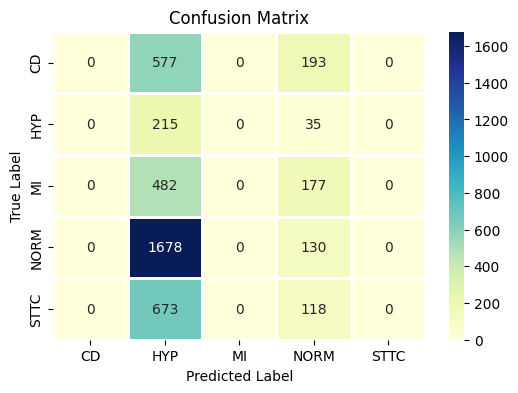

In [66]:
confusion_matrix = show_confusion_matrix(y_true, y_hat, classes)